# Alphavec Example

In this notebook we'll walkthrough backtesting a simple cost-aware crypto trend strategy with Alphavec.

>**Disclaimer**
>
>The content provided in this project is for informational purposes only and does not constitute financial advice. This information should not be construed as professional financial advice, and it is recommended to consult with a qualified financial advisor before making any financial decisions.
>
>No liability is accepted for any losses or damages incurred as a result of acting or refraining from action based on the information provided in this project. Use this information at your own risk.
>

## Imports

In [12]:
import os
import sys
import logging
from pathlib import PurePath
from functools import partial
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import alphavec.backtest as av

%matplotlib inline
%reload_ext autoreload
%autoreload 3

workspace_root = str(PurePath(os.getcwd()))
sys.path.append(workspace_root)

logging.basicConfig(
    format="%(asctime)s :: %(name)s :: %(levelname)s :: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S %z",
    level="INFO",
    force=True,
)
logger = logging.getLogger()

plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

## Load Data

Let's begin by loading our data.

We transform a flat file of daily candlestick (kline) data for a variety of crypto assets into the required format for backtesting: a single level DatetimeIndex with a column for each asset.

Close prices are used to generate our strategy weights.

Open prices are used to calculate the returns.

To prevent look-ahead bias we shift the open prices 2 periods during the backtest.

This approach implies we can execute our trades at the open price of the next bar after the strategy weights are generated - a reasonable assumption for low or mid frequency strategy in a 24 hour market like crypto.

In [13]:
def ohlcv_from_csv(filename):
    return pd.read_csv(
        filename,
        index_col=["symbol", "dt"],
        parse_dates=["dt"],
        dtype={
            "o": np.float64,
            "h": np.float64,
            "l": np.float64,
            "c": np.float64,
            "v": np.float64,
        },
        dayfirst=True,
    )


prices_filename = f"{workspace_root}/tests/testdata/binance-margin-1d.csv"
market = ohlcv_from_csv(prices_filename)
market = market[~market.index.duplicated()]
market = market.unstack(level=0).sort_index(axis=1).stack()

strategy_prices = pd.DataFrame(
    market.loc[:, ["c"]].unstack(level=1).droplevel(level=0, axis=1)
)

trade_prices = pd.DataFrame(
    market.loc[:, ["o"]].unstack(level=1).droplevel(level=0, axis=1)
)

display(trade_prices.tail())

symbol       BTCUSDT  DOGEUSDT  ETHUSDT  SOLUSDT  XRPUSDT
dt                                                       
2023-11-11  37301.63   0.07539  2077.72    56.67   0.6594
2023-11-12  37129.99   0.07850  2053.16    56.36   0.6626
2023-11-13  37064.13   0.07795  2044.69    56.27   0.6612
2023-11-14  36462.93   0.07456  2053.65    51.60   0.6701
2023-11-15  35551.20   0.07244  1979.40    56.81   0.6296

## Generate Forecast

Using the prices we create a simple risk-adjusted moving average cross forecast.

Handily, all the forecasts share a common scale because we've risk adjusted using the difference in price points.

<Axes: xlabel='dt'>

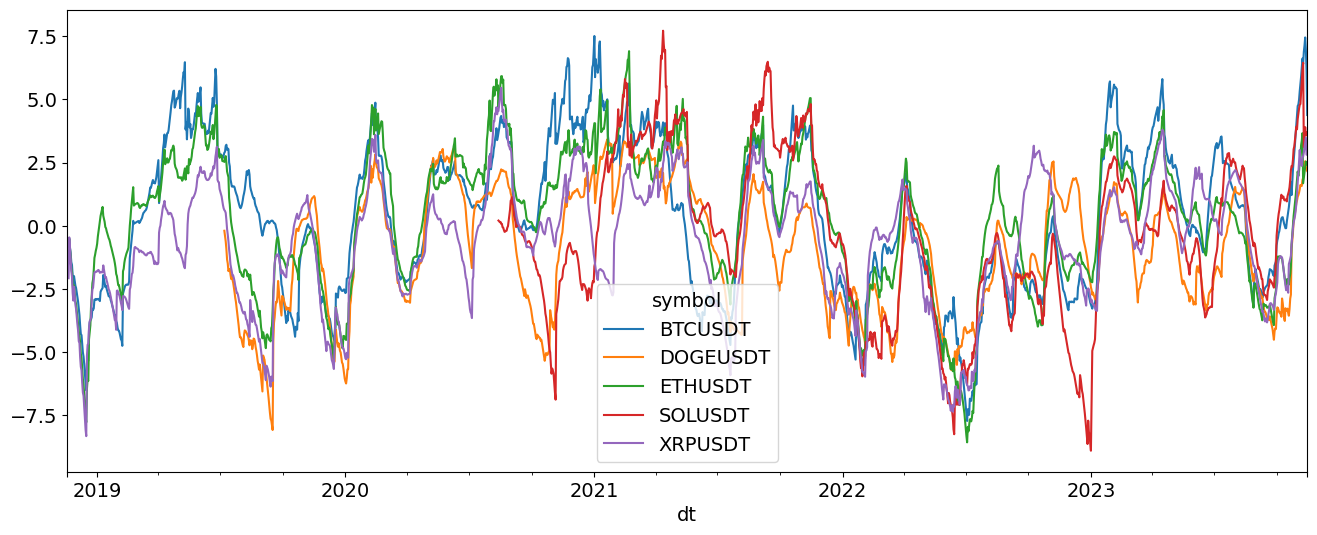

In [14]:
lookback = 16
forecast = (
    strategy_prices.ewm(span=lookback, adjust=False).mean()
    - strategy_prices.ewm(span=lookback * 4, adjust=False).mean()
).div(strategy_prices.diff().ewm(span=20).std())

forecast.plot()

## Distribute Weights

The final strategy weights are formed by normalizing the portfolio allocations so they sum to 1 at each interval.

For spice we simulate 2x leverage.

We do not perform any risk management in this simple example, a real-world strategy should consider how to adjust leverage based on market conditions and account state.

symbol       BTCUSDT  DOGEUSDT   ETHUSDT   SOLUSDT   XRPUSDT
dt                                                          
2023-11-11  0.785293  0.254109  0.232210  0.387244  0.341143
2023-11-12  0.764467  0.261963  0.237608  0.400291  0.335670
2023-11-13  0.738474  0.245006  0.268913  0.379070  0.368536
2023-11-14  0.708952  0.258903  0.280400  0.426825  0.324920
2023-11-15  0.567648  0.281168  0.322904  0.463675  0.364605

<Axes: xlabel='dt'>

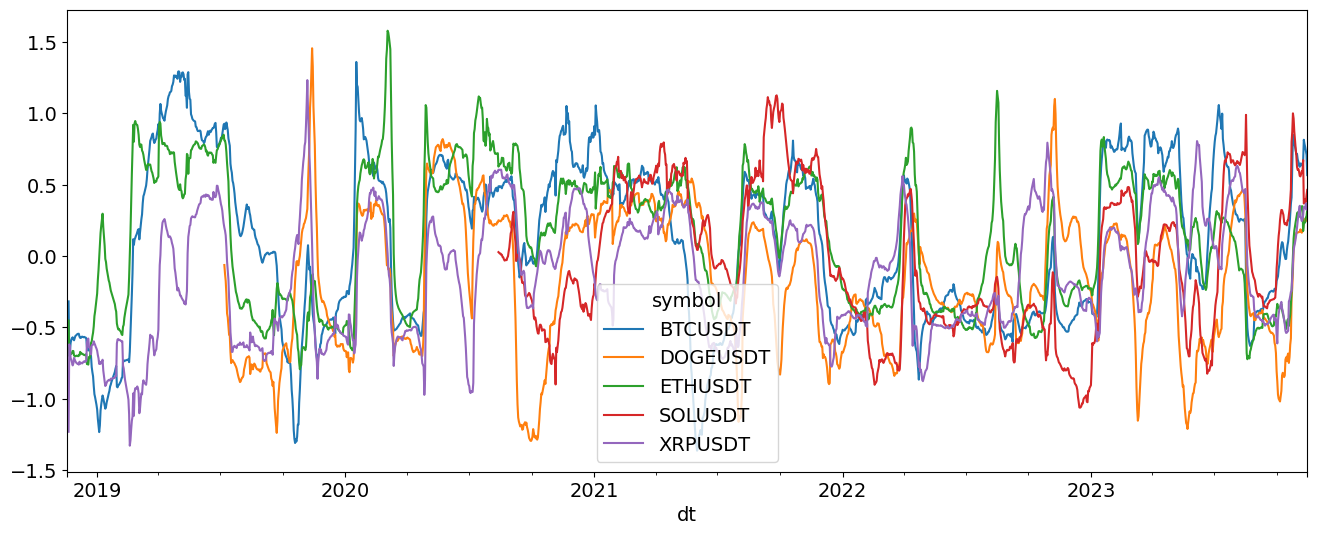

In [15]:
weights = forecast.div(forecast.abs().sum(axis=1), axis=0)
weights *= 2

display(weights.tail())
weights.plot()

## Execute Backtest

Finally we are ready to backtest.

However, we must take care to align the prices and weights.

During the backtest the returns calculated from the prices will be _shifted_ to prevent look-ahead bias.

This is a cost-aware backtest with fixed leverage. We've chosen cost parameters that mimic a typical crypto exchange.

Note how fast the backtest is even with 1000 bootstrap iterations to estimate portfolio metrics!

In [16]:
weights = weights["2019-01-01":]
trade_prices = trade_prices.mask(weights.isna())
trade_prices, weights = trade_prices.align(weights, join="inner")

perf, perf_curve, perf_sr, port_perf, port_rets = av.backtest(
    weights,
    trade_prices,
    freq_day=1,  # daily periods
    trading_days_year=365,  # crypto is a 365 market
    shift_periods=2,  # trade prices = open prices so we shift 2 periods
    commission_func=partial(av.pct_commission, fee_pct=0.001),  # 0.1% fee on each trade
    spread_pct=0.0005,  # 0.05% spread on each trade
    ann_borrow_rate=0.05,  # 5% annual borrowing rate for leveraged positions
    is_perp_funding=True,  # borrow rate is applied to all positions all the time to simulate perpetual futures funding
    ann_risk_free_rate=0,  # 0% risk free rate used to calculate Sharpe ratio
    bootstrap_n=1000,  # number of bootstrap iterations to calculate confidence intervals
)

2025-01-07 11:58:45 +0000 :: root :: INFO :: Executing backtest for 5 assets over 1780 periods with 1000 bootstrap iterations...
2025-01-07 11:58:45 +0000 :: root :: INFO :: Backtest complete in 0.55 seconds.


## Analyse Results

Let's look at the performance of the strategy, starting with the asset-wise view, then the portfolio view.

Asset performance is the baseline buy-and-hold over the period.

Strategy performance is the performance of our generated weights.

We note that the BTC component of our strategy had better risk adjusted returns (Sharpe) than the baseline buy-and-hold, likewise so did SOL. However the other components underformed.

In [17]:
display(perf)

asset                                               strategy  \
         annual_sharpe annual_volatility      cagr max_drawdown annual_sharpe   
symbol                                                                          
BTCUSDT       0.680140          0.695804  0.605193    -0.766293      0.981600   
DOGEUSDT      0.490918          1.450612  1.038332    -0.923328     -0.023339   
ETHUSDT       0.629351          0.895686  0.757164    -0.793027      0.168228   
SOLUSDT       0.613386          1.357757  1.299816    -0.962695      0.919672   
XRPUSDT       0.123421          1.065146  0.140493    -0.832385     -0.536392   

                                                                   
         annual_volatility      cagr max_drawdown annual_turnover  
symbol                                                             
BTCUSDT           0.413514  0.500661    -0.315680        1.031485  
DOGEUSDT          0.555047 -0.012871    -0.744977        3.895460  
ETHUSDT           0.448608  0.078389    -0.556279        3.643342  
SOLUSDT           0.640360  0.802043    -0.667801        1.175677  
XRPUSDT           0.413993 -0.199135    -0.727127        7.932329

Next lets review the compounded equity curves (excl. portfoilo) to see account value progression over time.

As we can observe clearly in the equity curve the buy-and-hold on MATIC performed the best in terms of absolute returns.

<Axes: xlabel='dt'>

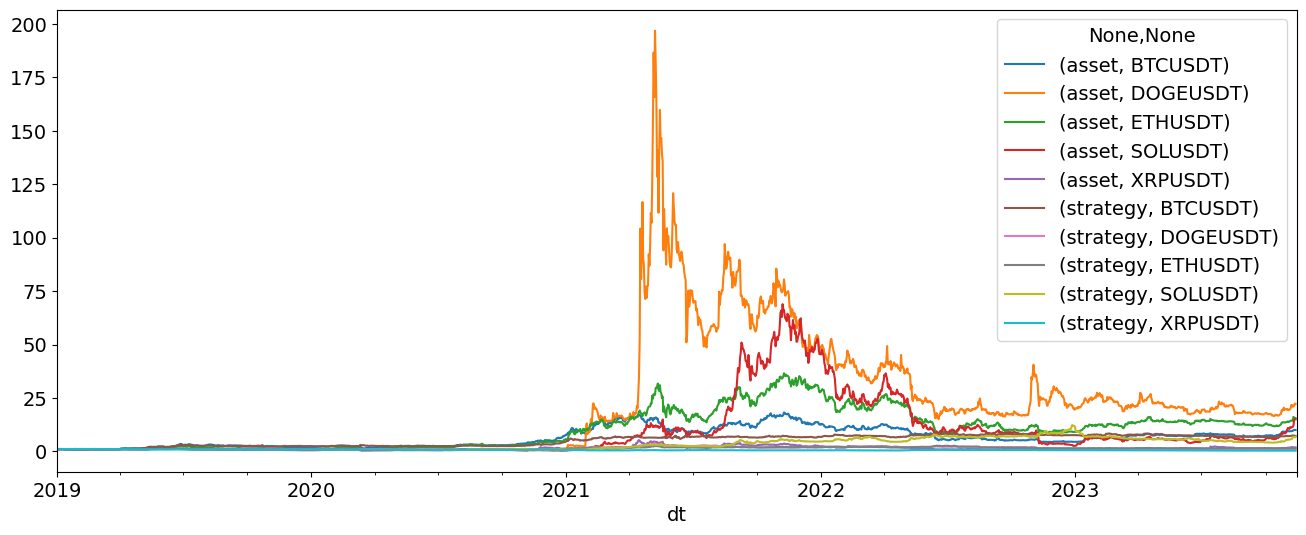

In [18]:
perf_curve.drop(("portfolio", "equity_curve"), axis=1).plot()

Similarly, lets see how risk-adjusted returns (annualized Sharpe) progress over time.

Here we can see there is no clear winner.

<Axes: xlabel='dt'>

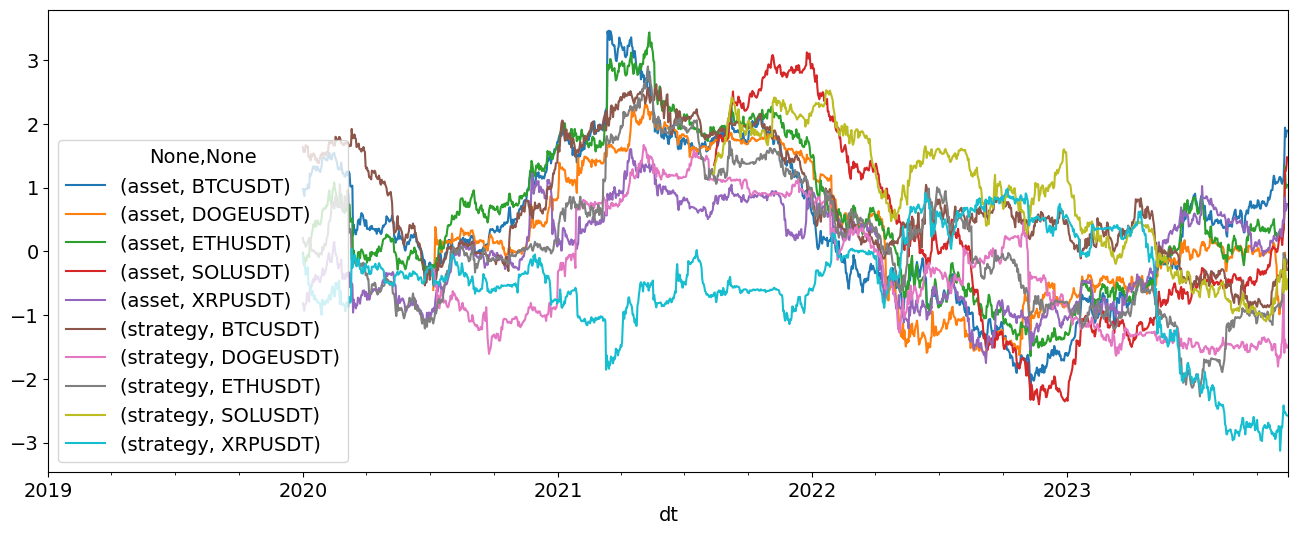

In [19]:
perf_sr.drop(("portfolio", "sharpe"), axis=1).plot()

Now we'll turn to our aggregate portfolio performance.

**Observed** is the actual backtested performance of our strategy.

But as we know backtests are fallible and are no guarantee of future performance. 

Validating the robustness of a trading strategy can take many forms. Alphavec offers a simple way to understand the potential variance of your strategy by providing estimates of the confidence interval for each metric. These estimates are generated using a bootstrap sampling method on the observed porfolio returns.

Here we observe a rather modest 0.5 Sharpe for our strategy in aggregate, with volatility at a stomach churning 140%... an expected consequence of applying fixed leverage to an already highly volatile asset class.

The lower confidence limit (p = 0.5) tells us that out-of-sample in the real world we could actually expect a negative Sharpe of -0.3 and overall a loss. Clearly we would be fool hardy to consider trading this strategy in live.

In [20]:
display(port_perf)

annual_sharpe  annual_volatility    cagr  max_drawdown  \
observed         0.4548             1.4080  0.8971       -0.9562   
mean             0.4705             1.4024  1.3369       -0.8968   
std              0.4385             0.0621  1.5854        0.0763   
median           0.4695             1.3993  0.9240       -0.9116   
ucl.95           1.2992             1.5417  5.2530       -0.7135   
lcl.95          -0.3561             1.2881 -0.4058       -0.9949   

          annual_turnover  
observed           2.3389  
mean               2.3389  
std                0.0000  
median             2.3389  
ucl.95             2.3389  
lcl.95             2.3389

Plot the compounded equity curve of the portfolio, followed by the simple cumulated returns.

The latter plot is helpful in enabling us to better see the underlying trend.

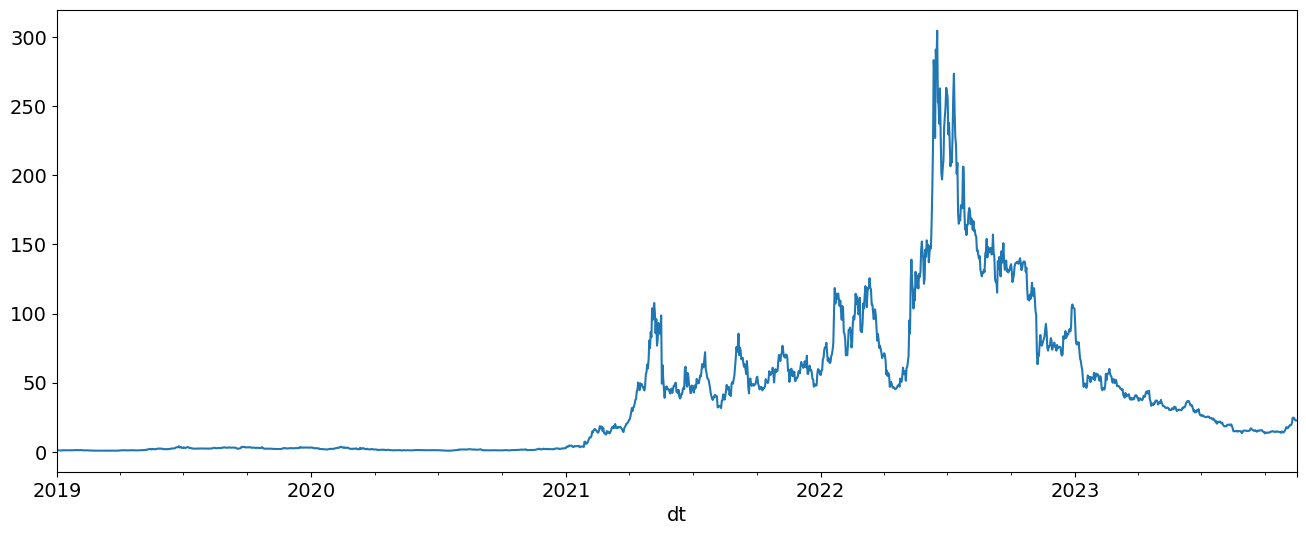

<Axes: xlabel='dt'>

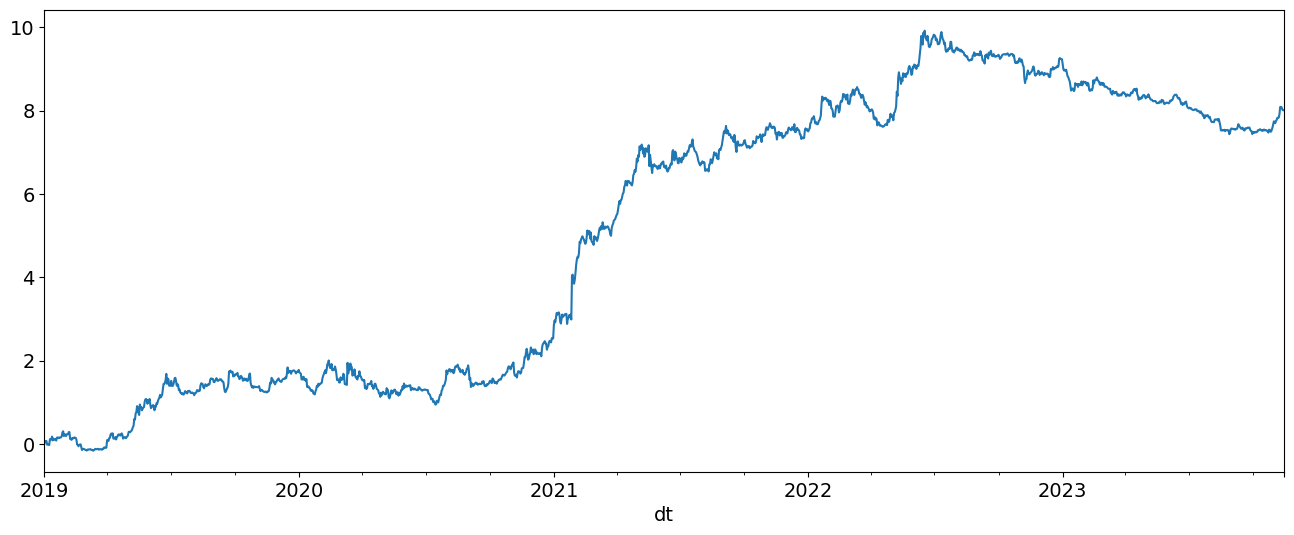

In [21]:
port_curve = perf_curve.loc[:, ("portfolio", "equity_curve")]
port_curve.plot()
plt.show()

(np.exp(port_rets) - 1).cumsum().plot()

Using the rolling Sharpe series we can get a sense of the risk adjusted returns by year.

<Axes: xlabel='dt'>

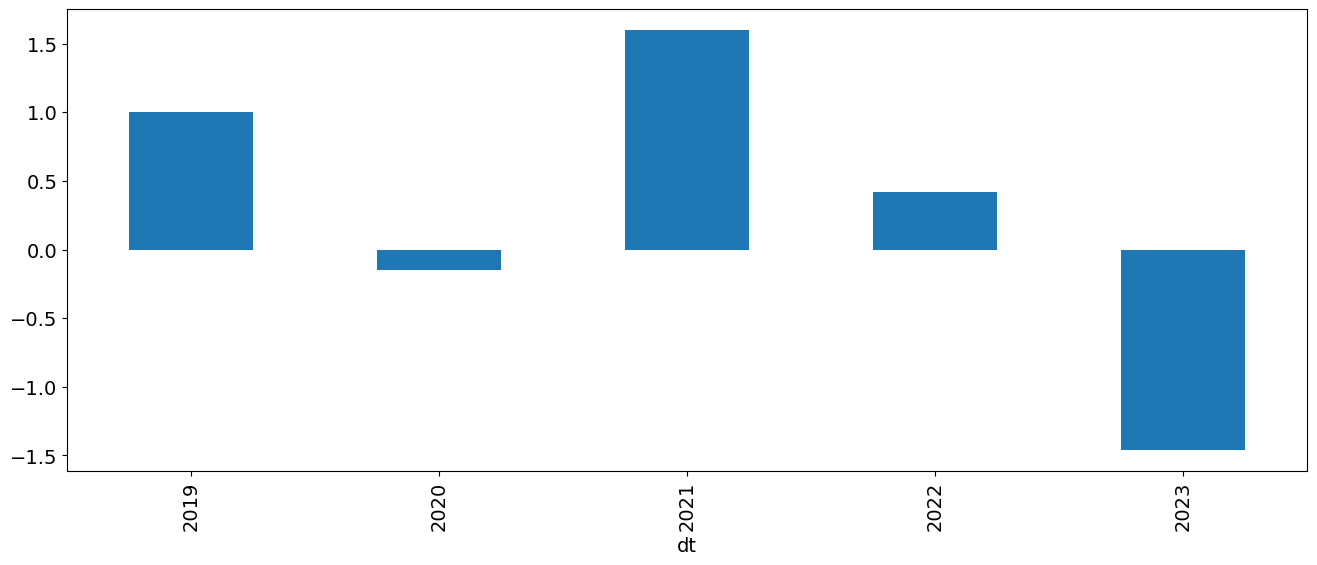

In [22]:
perf_sr.loc[:, ("portfolio", "sharpe")].resample("Y").last().rename(
    lambda x: x.strftime("%Y")
).plot(kind="bar")

In conclusion, the performance of our toy strategy leaves a lot to be desired!

To understand a more sophistcated real-world variant of this strategy I validated with Alphavec read on...